# Imports

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
from astropy.table import Table, Column, join, vstack
from astropy.io import fits
import subprocess
from os import path
from IPython.display import display
from IPython.display import Image
import glob, os
import sep
from astropy.stats import mad_std
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import sigma_clipped_stats

# Increase notebook width to 100% of page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Profile Code

In [2]:
def function(name):
    im = pyfits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/imgblock_{name}.fits')
    model_hdu = im[2]
    _h = model_hdu.header
    fittype = str(_h['COMP_1'])
    if fittype == 'psf':
        print('I\'m in the loop')
function('c_38281')

NameError: name 'pyfits' is not defined

In [3]:
#!/usr/bin/env python
# encoding: utf-8
# For psf fits, set n, pa, ar, and re instead of getting them from header (because galfit output header simply skips these for psf fits)
"""
deconvolve.py

GALFIT "deconvolution" as in Szomoru et al. 
https://iopscience.iop.org/article/10.1088/2041-8205/714/2/L244

"""

import numpy as np

import astropy.io.fits as pyfits
import astropy.stats
import astropy.table

def test(name):
    
    im = pyfits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/imgblock_{name}.fits')
    model_hdu = im[2]
    residuals = im[3].data
    rms = pyfits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/cont_sigma_{name}.fits')[0].data
    
    _ = galfit_deconvolve(model_hdu, residuals, rms=rms)

#     model_hdu = _x['model']
#     residuals = _x['resid'].data
    
    imshow_args={'vmin':-5, 'vmax':5, 'cmap':'viridis'}
    
#     _ = galfit_deconvolve(model_hdu, residuals, rms=_x['rms'], imshow_args=imshow_args)
    
def galfit_deconvolve(model_hdu, residuals, rms=None, mask=None, oversample=8, comp='1', xprof=np.append(0, np.arange(2,20)), y_func=np.mean, cumul_values=[0.5], make_plot=True, imshow_args={'vmin':-5, 'vmax':5, 'cmap':'viridis'}, plt_kwargs={'linestyle':'steps-mid', 'color':'r', 'alpha':0.8}, npix=20, psf_offset=[1,1]):
    """
    Deconvolve an image using a galfit Sersic model
    
    `model_hdu` is the HDU output from GALFIT containing the model and model
    parameters (e.g, out.fits[2]).
    
    `residuals` are the fit residuals (out.fits[3].data)
    
    `psf_offset` is the offset of the PSF relative to the central pixel of 
    the PSF array.
    
    Returns:
        
        R = radii evaluated at pixel positions for the ellipse parameters
        phi = position angle around the ellipse, radians
        prof = 2D array of unconvolved Sersic profile
        params = Galfit params
        tab = table of the 1D profile
        fig = optional figure if `make_plot=True`
        
    """
    
    _h = model_hdu.header
    shape = residuals.shape
    
    if mask is None:
        mask = np.isfinite(residuals)
        
    # Ellipse parameters and sersic profile
    R, phi, prof, params = sersic_profile(shape, oversample=oversample, 
                                          gf_header=_h, comp=comp, 
                                          psf_offset=psf_offset)
    print(f'R = {R}')
    so = np.argsort(R[mask].flatten())
    Rso = R[mask].flatten()[so]           # this is like the selection code, isn't it?
    print(f'Rso = {Rso}')
    data = residuals + model_hdu.data
        
    if '1_SKY' in _h:
        sky = gf_header_key(_h, '1_SKY')
    else:
        sky = 0.
    
    ##########
    # 1D averaged profiles
    
    integ = False
    
    # Original data
    _, ydata, _, _ = running_median(Rso,
                (data)[mask].flatten()[so].astype(np.float)-sky, 
                bins=xprof, use_median=False, y_func=y_func, integrate=integ)
    
    # Sersic profile
    _, yprof, _, _ = running_median(Rso,
                (prof)[mask].flatten()[so].astype(np.float), 
                bins=xprof, use_median=False, y_func=y_func, integrate=integ)
    
    # Sersic + residuals
    xm, ydeconv, ys, yn = running_median(Rso,
                (prof + residuals)[mask].flatten()[so].astype(np.float), 
                bins=xprof, use_median=False, y_func=y_func, integrate=integ)
    
    # Sum for total normalizatioin
    _, ydeconv_sum, _, _ = running_median(Rso, 
                (prof + residuals)[mask].flatten()[so].astype(np.float), 
                bins=xprof, use_median=False, y_func=np.sum, integrate=False)
    
    # Variance
    if rms is not None:
        xmx, yv, yvs, yn = running_median(Rso, 
                rms[mask].flatten()[so].astype(np.float)**2, 
                bins=xprof, use_median=False, y_func=np.sum)

        yrms = np.sqrt(yv)/yn
        im_norm = rms
    else:
        yrms = ys
        im_norm = 1
        
    dx = np.diff(xprof)
    xpix = xprof[1:]-dx/2.

    if False:
        # Scale
        yscl = 1.

        #yscl = prof[msk].sum()/np.trapz(2*np.pi*yprof*xpix, xpix)
        yprof *= yscl
        ydeconv *= yscl
        yrms *= yscl
    
    # Interpolate Radii from the cumulative flux distribution
    cumul_flux = np.cumsum((prof + residuals)[mask].flatten()[so])
    
    #total = cumflux.max()
    total = ydeconv_sum.sum()

    Rcumul = np.interp(cumul_values, cumul_flux/total, Rso)
    print(f'Rcumul = {Rcumul}')
    tab = astropy.table.Table()  # Why didn't this work for me? Because I wanted to add things row-wise instead of column_wise??
    tab['xpix'] = xpix
    tab['yprofile'] = yprof
    tab['ydeconv'] = ydeconv
    tab['yrms'] = yrms
    tab['ydata'] = ydata
    
    tab.meta['total_flux'] = total
    for k in params:
        tab.meta[k] = params[k]
    
    for i, r in enumerate(cumul_values):
        tab.meta['R{0}'.format(int(r*100))] = Rcumul[i]
        
    params['Rcumul'] = Rcumul
        
    if make_plot:
        
        fig = plt.figure(figsize=(12,3))
        ax = fig.add_subplot(141)
        ax2 = fig.add_subplot(142)
        ax3 = fig.add_subplot(143)
        
        ax4 = fig.add_subplot(144)
        ax4.loglog()
        ax4.grid()
        
        xc = float(_h[comp+'_XC'].strip('[]').split()[0])
        yc = float(_h[comp+'_YC'].strip('[]').split()[0])
        # added .strip(‘[]') before .split()
    
        ax.imshow(data/im_norm*mask, **imshow_args)
        ax.set_title(name)
        ax2.imshow(residuals/im_norm*mask, **imshow_args)    
        ax3.imshow(prof/im_norm*mask, **imshow_args)    
        
        label = 'Re={re:.2f}, n={n:.1f}'.format(**params)
        pl = ax4.plot(xpix, yprof, label=label, **plt_kwargs)
        
        ax4.errorbar(xpix, ydeconv, yrms, linestyle='None', 
                     color=pl[0].get_color(), alpha=0.5, marker='.')
        
        ax4.vlines(params['re'], 1e-10, 1e10, color=pl[0].get_color(), alpha=0.5)
        ax4.vlines(Rcumul, 1e-10, 1e10, color=pl[0].get_color(), alpha=0.5, linewidth=3, linestyle='--')
    
        ax4.scatter(Rso, 
                (prof + residuals)[mask].flatten()[so].astype(np.float)-sky, 
                marker='.', color='k', alpha=0.1, zorder=-1000)

#         ax4.scatter(Rso, 
#                (data)[mask].flatten()[so].astype(np.float)-sky, 
#                marker='.', color='aqua', alpha=0.1, zorder=-1000)
        
        ax4.legend()
        
        valid = np.isfinite(ydeconv) & np.isfinite(yprof)
        
#         print(ydeconv[valid].min(), ydeconv[valid].max())
        
        try:
            ax4.set_ylim(np.maximum(0.5*yprof[valid].min(), 1e-5*ydeconv[valid].max()),
                     2*ydeconv[valid].max())
        except:
            pass
            
        ax4.set_xlim(0.05, xprof.max()+2)
    
        for a in [ax, ax2, ax3]:
            a.set_xlim(xc-1-npix, xc-1+npix)
            a.set_ylim(yc-1-npix, yc-1+npix)
            a.set_xticklabels([])
            a.set_yticklabels([])
            
            # Show ellipses on images
            a.plot(*r_ellipse(Rcumul[0], psf_offset=psf_offset, **params), 
                   color='w', alpha=0.9, linewidth=2)
            a.plot(*r_ellipse(xpix.max(), psf_offset=psf_offset, **params), 
                   color='w', alpha=0.9, linewidth=2)

            a.plot(*r_ellipse(Rcumul[0], psf_offset=psf_offset, **params), 
                   color=pl[0].get_color(), alpha=0.5)
            a.plot(*r_ellipse(xpix.max(), psf_offset=psf_offset, **params), 
                   color=pl[0].get_color(), alpha=0.5, linestyle='--')
            
        fig.tight_layout(pad=0.1)
        
    else:
        fig = None

    return R, phi, prof, params, tab, fig
    
    
def get_kappa(n, **kwargs):
    """
    Compute the Kappa parameter for a given n index as in the Galfit
    definition
    """
    from scipy.optimize import root
    x0 = 2*n-0.33
    args=(n)
    k = root(kappa_func, x0, args=args, **kwargs)
    return k.x[0]
    
def kappa_func(kappa, n):
    """
    Function for getting Sersic kappa
    """
    from scipy.special import gamma, gammainc
    f = gamma(2*n)-2*gammainc(2*n, kappa)*gamma(2*n)
    return f

def Rc(c0):
    """
    Shape parameter
    """
    from scipy.special import beta
    
    return np.pi*(c0+2)/(4*beta(1./(c0+2), 1+1./(c0+2)))

def sigma_e(re, n, q, Ftot=1., c0=0.):
    """
    Surface brightess at the effective radius, re, given total flux
    """
    from scipy.special import gamma
    kap = get_kappa(n)
#     print(f're = {re}')
    return Ftot/(2*np.pi*re**2*np.exp(kap)*n*kap**(-2*n)*gamma(2*n)*q/Rc(c0)), kap
    
def gf_header_key(header, key='2_XC'):
    """
    Get a header keyword from a GALFIT header, which may have [] and *
    in the keyword value
    """
    return float(header[key].split()[0].strip('[]').strip('*'))
    
def sersic_profile(shape, mag=20., xc=[0., 0.], n=1., q=0.5, pa=0, re=1., ZP=26., gf_header=None, comp='1', verbose=True, oversample=8, psf_offset=[1,1]):
    # Changed comp from '2' to '1'
    """
    Generate a Sersic profile with Galfit parameters within a defined image 
    shape.
    
    Specify the parameters individually or provide a GALFIT model header
    
    gf_header: FITS header of a GALFIT output model 
    comp: Number of the object in the GALFIT model
    
    """
    import scipy.ndimage as nd
    
    if gf_header is not None:
        fittype = str(gf_header['COMP_1'])
        xx = gf_header_key(gf_header, comp+'_XC')
        yy = gf_header_key(gf_header, comp+'_YC')
        xc = np.array([xx, yy])
        mag = gf_header_key(gf_header, comp+'_MAG')

        if fittype != 'sersic':
#         if fittype.startswith('psf'):
            n = 1
            q = 1
            pa = 60
            re = 1
        else:
            n = gf_header_key(gf_header, comp+'_N')
            q = gf_header_key(gf_header, comp+'_AR')
            pa = gf_header_key(gf_header, comp+'_PA')
            re = gf_header_key(gf_header, comp+'_RE')
        
        if 'MAGZPT' in gf_header:
            ZP = gf_header['MAGZPT']
            
    params = {'mag':mag, 'xc':xc, 're':re, 'n':n, 'q':q, 'pa':pa}
    
    sigm, kap = sigma_e(re, n, q)
    norm = sigm*10**(-0.4*(mag-ZP))
    R, x, phi = pix_to_r(shape, verbose=verbose, psf_offset=psf_offset, 
                         **params)

    if oversample > 1:
        Ro, x, phi = pix_to_r(shape, oversample=oversample, verbose=verbose,
                              psf_offset=psf_offset, **params)
                              
        sersic_large = norm*np.exp(-kap*((Ro/re)**(1./n)-1))
        kern = np.ones((oversample, oversample))/oversample**2
        sersic_profile = nd.convolve(sersic_large, kern)[oversample//2-1::oversample, oversample//2-1::oversample]
    else:
        sersic_profile = norm*np.exp(-kap*((R/re)**(1./n)-1))
        
    return R, phi, sersic_profile, params

def r_ellipse(radius, xc=[0., 0.], q=0.5, pa=0, re=1., gf_header=None, comp='1', verbose=True, nstep=256, psf_offset=[1,1], **kwargs):
    # Changed comp from '2' to '1'
    """
    Make x, y coordinates given ellipse parameters
    """
    if gf_header is not None:
        fittype = str(gf_header['COMP_1'])
        xx = gf_header_key(gf_header, comp+'_XC')
        yy = gf_header_key(gf_header, comp+'_YC')
        xc = np.array([xx, yy])
        mag = gf_header_key(gf_header, comp+'_MAG')

        if fittype != 'sersic':
#         if fittype.startswith('psf'):
            n = 1
            q = 1
            pa = 60
            re = 1
        else:
            n = gf_header_key(gf_header, comp+'_N')
            q = gf_header_key(gf_header, comp+'_AR')
            pa = gf_header_key(gf_header, comp+'_PA')
            re = gf_header_key(gf_header, comp+'_RE')

    
    # parametric equation of ellipse: x = a cos t, y = b sin t; t = area subtended on circle not ellipse (https://www.mathopenref.com/coordparamellipse.html)
    
    phi = np.linspace(0, 2*np.pi, nstep)
    xp = np.array([np.cos(phi), q*np.sin(phi)]).T*radius # .T => transpose
      
    theta = -(np.pi/2 + pa/180*np.pi) #+ np.pi
    
    _rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    x0 = xp.dot(_rot) + np.atleast_1d(xc) #.dot => dot product. But why do I need a dot product? To get the cos??
    xell, yell = (x0 - 1 - np.atleast_1d(psf_offset)).T
    
    return xell, yell
    
        
def pix_to_r(shape, xc=[0., 0.], q=0.5, pa=0, re=1., gf_header=None, comp='1', verbose=True, oversample=1, psf_offset=[1,1], **kwargs):
    # Changed comp from '2' to '1'
    """
    Return an array of ellipse radii for a pixel grid and ellipse parameters
    """
    
    if oversample > 1:
        xarr = np.arange(-0.5, shape[1]-0.5, 1/oversample)
        yarr = np.arange(-0.5, shape[0]-0.5, 1/oversample)
    else:
        xarr = np.arange(0, shape[1], 1/oversample)
        yarr = np.arange(0, shape[0], 1/oversample)
        
    x0 = np.array(np.meshgrid(xarr, yarr)).reshape((2,-1)).T + 1
    x0 += np.atleast_1d(psf_offset)
    
    if gf_header is not None:
        fittype = str(gf_header['COMP_1'])
        xx = gf_header_key(gf_header, comp+'_XC')
        yy = gf_header_key(gf_header, comp+'_YC')
        xc = np.array([xx, yy])
        mag = gf_header_key(gf_header, comp+'_MAG')
        
        if fittype != 'sersic':
#         if fittype.startswith('psf'):
            n = 1
            q = 1
            pa = 60
            re = 1
        else:
            n = gf_header_key(gf_header, comp+'_N')
            q = gf_header_key(gf_header, comp+'_AR')
            pa = gf_header_key(gf_header, comp+'_PA')
            re = gf_header_key(gf_header, comp+'_RE')

            
    theta = (np.pi/2 + pa/180*np.pi) #+ np.pi
    
    _rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    xp = (x0 - np.atleast_1d(xc)).dot(_rot)
    
    outshape = [s*oversample for s in shape]
    
    R = np.sqrt(((xp/np.array([1, q]))**2).sum(axis=1)).reshape(outshape)
    print(f'ds9_R = {R}')
    phi = np.arctan2(xp[:,1], xp[:,0]).reshape(outshape)
    
    return R, re, phi
    
    ds9.view(R)

def running_median(xi, yi, NBIN=10, use_median=True, use_nmad=True, reverse=False, bins=None, x_func=astropy.stats.biweight_location, y_func=astropy.stats.biweight_location, std_func=astropy.stats.biweight_midvariance, integrate=False):
    """
    Running median/biweight/nmad
    """
    
    NPER = xi.size // NBIN
    if bins is None:
        so = np.argsort(xi)
        if reverse:
            so = so[::-1]
        
        bx = np.linspace(0,len(xi),NBIN+1)
        bins = np.interp(bx, np.arange(len(xi)), xi[so])
        if reverse:
            bins = bins[::-1]
    
    NBIN = len(bins)-1
           
    xm = np.arange(NBIN)*1.
    xs = xm*0
    ym = xm*0
    ys = xm*0
    N = np.arange(NBIN)
    
    if use_median:
        y_func = np.median
    
    if use_nmad:
        std_func = astropy.stats.mad_std
        
    for i in range(NBIN):
        in_bin = (xi > bins[i]) & (xi <= bins[i+1])
        N[i] = in_bin.sum() #N[i] = xi[so][idx+NPER*i].size
        
        if integrate:
            xso = np.argsort(xi[in_bin])
            ma = xi[in_bin].max()
            mi = xi[in_bin].min()
            xm[i] = (ma+mi)/2.
            dx = (ma-mi)
            ym[i] = np.trapz(yi[in_bin][xso], xi[in_bin][xso])/dx
        else:
            xm[i] = x_func(xi[in_bin])
            ym[i] = y_func(yi[in_bin])
        
        ys[i] = std_func(yi[in_bin])
                    
    return xm, ym, ys, N

256 2 256 256


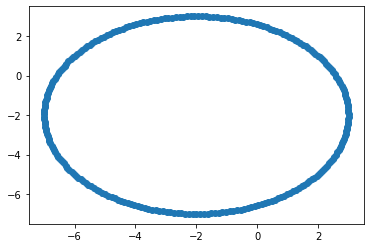

In [35]:
phi = np.linspace(0, 2*np.pi, 256)
xp = np.array([np.cos(phi), np.sin(phi)]).T*5
theta = -(np.pi/2 + 60/180*np.pi) #+ np.pi
_rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])    
xc = [0,0]
x0 = xp.dot(_rot) + np.atleast_1d(xc)
xell, yell = (x0 - 1 - np.atleast_1d([1,1])).T
print(len(xp), len(_rot), len(xp.dot(_rot)), len(np.dot(xp,_rot)))
x = toplot[:,0]
y = toplot[:,1]
plt.plot(xell,yell,'o')

In [38]:
np.dot(xp,_rot)

array([[-4.33012702e+00,  2.50000000e+00],
       [-4.39040624e+00,  2.39255785e+00],
       [-4.44802006e+00,  2.28366318e+00],
       [-4.50293351e+00,  2.17338211e+00],
       [-4.55511325e+00,  2.06178159e+00],
       [-4.60452759e+00,  1.94892937e+00],
       [-4.65114654e+00,  1.83489396e+00],
       [-4.69494180e+00,  1.71974459e+00],
       [-4.73588678e+00,  1.60355118e+00],
       [-4.77395662e+00,  1.48638425e+00],
       [-4.80912822e+00,  1.36831495e+00],
       [-4.84138020e+00,  1.24941495e+00],
       [-4.87069301e+00,  1.12975643e+00],
       [-4.89704884e+00,  1.00941205e+00],
       [-4.92043169e+00,  8.88454849e-01],
       [-4.94082736e+00,  7.66958274e-01],
       [-4.95822348e+00,  6.44996083e-01],
       [-4.97260948e+00,  5.22642316e-01],
       [-4.98397662e+00,  3.99971256e-01],
       [-4.99231802e+00,  2.77057375e-01],
       [-4.99762860e+00,  1.53975293e-01],
       [-4.99990514e+00,  3.07997332e-02],
       [-4.99914625e+00, -9.23945248e-02],
       [-4.

In [39]:
xp.dot(_rot)

array([[-4.33012702e+00,  2.50000000e+00],
       [-4.39040624e+00,  2.39255785e+00],
       [-4.44802006e+00,  2.28366318e+00],
       [-4.50293351e+00,  2.17338211e+00],
       [-4.55511325e+00,  2.06178159e+00],
       [-4.60452759e+00,  1.94892937e+00],
       [-4.65114654e+00,  1.83489396e+00],
       [-4.69494180e+00,  1.71974459e+00],
       [-4.73588678e+00,  1.60355118e+00],
       [-4.77395662e+00,  1.48638425e+00],
       [-4.80912822e+00,  1.36831495e+00],
       [-4.84138020e+00,  1.24941495e+00],
       [-4.87069301e+00,  1.12975643e+00],
       [-4.89704884e+00,  1.00941205e+00],
       [-4.92043169e+00,  8.88454849e-01],
       [-4.94082736e+00,  7.66958274e-01],
       [-4.95822348e+00,  6.44996083e-01],
       [-4.97260948e+00,  5.22642316e-01],
       [-4.98397662e+00,  3.99971256e-01],
       [-4.99231802e+00,  2.77057375e-01],
       [-4.99762860e+00,  1.53975293e-01],
       [-4.99990514e+00,  3.07997332e-02],
       [-4.99914625e+00, -9.23945248e-02],
       [-4.

# Fitting Function

In [4]:
def fit(name, **kwargs): # cont and line args in the form of line = [(fittype1,extracx1,extracy1,rad1,extramag1),...], cont = [(fittype2,extracx2,extracy2,rad2,extramag2)],...]
    
    # Set default args and separate cont and line args
    if not kwargs:
        cargs = [('sersic',0,0,2,0)]
    for key, value in kwargs.items():
        if key == 'cont':
            cargs = value
   
    # Define magnitude zeropoint
    zeropoint = 18
    
    # Define cutout size
    cutout_low = 40
    cutout_high = 80

    idx = name[2:]
    if name[0] == 'c':
        root = 'cos-g800l-j100012p0210'
        filt = 'F814W'
    if name[0] == 'u':
        root = 'uds-g800l-j021732m0512'
        filt = 'F814W'
    if name[0] == 'e':
        root = 'egs-g800l-j141956p5255'
        filt = 'F814W'
    if name[0] == 'n':
        root = 'gdn-g800l-j123656p6215'
        filt = 'F850LP'
    if name[0] == 's':
        root = 'gds-g800l-j033236m2748'
        filt = 'F850LP'

    # Read in input lya file for ra, dec, and line ap mag, read in cont file for cont ap mag
    im = fits.open(f'/Users/meghanakilli/Documents/PP/Data/grism/{root}_{idx}.fits')
    lya = im['LINE', 'Lya']
    ra = lya.header['CRVAL1']
    dec = lya.header['CRVAL2']
    seg = im['SEG'].data
    seg[57:63,57:63] = 0

    # New continuum images
    im = fits.open(f'/Users/meghanakilli/Documents/PP/Data/lya_thumbnails/{root}_{idx}.x.thumb.fits')
    cont = im['SCI', filt].data
    contwt = im['WHT', filt].data

    # Sky background calculation
    mask = seg > 0
    _, median_sigclip, _ = sigma_clipped_stats(cont[mask])
    skyback = median_sigclip

    # Magnitude calculation - std or zero correction???
    aperture = CircularAperture((60,60),5)

    # zero corrected, not skyback subtracted
    zeroarray = np.zeros(cont.shape, dtype=cont.dtype)
    zero_corrected_data = np.maximum(cont, zeroarray)
    flux = aperture_photometry(zero_corrected_data, aperture)['aperture_sum'][0]

    mag = zeropoint - 2.5*np.log10(flux)

    # Fit sersic to lya
    f = open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/galfit_{name}.feedme','w+')
    f.write('\n===============================================================================\n')
    f.write('# IMAGE and GALFIT CONTROL PARAMETERS\n')
    f.write(f'A) cont_sci_{name}.fits                 # Input data image (FITS file)\n')
    f.write(f'B) imgblock_{name}.fits                 # Output data image block\n')
    f.write(f'C) cont_sigma_{name}.fits               # Sigma image name (made from data if blank or "none")\n')
    f.write(f'D) psf_{name}.fits                      # Input PSF image and (optional) diffusion kernel\n') #{root}_{idx}.x.
    f.write('E) 1                                     # PSF fine sampling factor relative to data \n')
    f.write(f'F) cont_mask_{name}.fits                # Bad pixel mask (FITS image or ASCII coord list)\n')
    f.write('G) constraint.txt                        # File with parameter constraints (ASCII file)\n')
    f.write('H) 1    120   1    120                   # Image region to fit (xmin xmax ymin ymax)\n') # because this was counting both 50 and 70, so it was giving me a 21x21 box instead of 20x20
    f.write('I) 120    120                            # Size of the convolution box (x y)\n')
    f.write(f'J) {zeropoint}                          # Magnitude photometric zeropoint\n')
    f.write('K) 0.05  0.05                            # Plate scale (dx dy)    [arcsec per pixel]\n')
    f.write('O) regular                               # Display type (regular, curses, both)\n')
    f.write('P) 0                                     # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps\n')
    f.write('\n# INITIAL FITTING PARAMETERS\n#\n')
    f.write('#   For object type, the allowed functions are:\n') 
    f.write('#       nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat, \n')
    f.write('#       ferrer, powsersic, sky, and isophote. \n#  \n')
    f.write('#   Hidden parameters will only appear when they\'re specified:\n')
    f.write('#       C0 (diskyness/boxyness), \n')
    f.write('#       Fn (n=integer, Azimuthal Fourier Modes),\n')
    f.write('#       R0-R10 (PA rotation, for creating spiral structures).\n#\n') 
    f.write('# -----------------------------------------------------------------------------\n')
    f.write('#   par)    par value(s)    fit toggle(s)    # parameter description \n')
    f.write('# -----------------------------------------------------------------------------\n\n')

    for number in range(len(cargs)): # number of components to initialize
        f.write(f'# Object number: {number+1}\n')
        f.write(f' 0) {cargs[number][0]}                                        #  object type\n')
        f.write(f' 1) {60+cargs[number][1]}  {60+cargs[number][2]}    1    1    #  position x, y\n')
        f.write(f' 3) {mag+cargs[number][4]}              1                     #  Integrated magnitude\n')
        f.write(f' 4) {cargs[number][3]}                  1                     #  R_e (half-light radius)   [pix]\n')
        f.write(f' 5) 1       1                                                 #  Sersic index n (de Vaucouleurs n=4)\n')
        f.write(' 6) 0.0000          0                                          #     ----- \n')
        f.write(' 7) 0.0000          0                                          #     ----- \n')
        f.write(' 8) 0.0000          0                                          #     -----\n')
        f.write(f' 9) 0.1         1                                             #  axis ratio (b/a)\n')
        f.write(f'10) -45         1                                             #  position angle (PA) [deg: Up=0, Left=90]\n')
        f.write(' Z) 0                                                          #  output option (0 = resid., 1 = Don\'t subtract)\n\n')

    f.write('# Object number: 7\n')
    f.write(' 0) sky                                  #  object type\n')
    f.write(f' 1) {skyback}      0                    #  sky background at center of fitting region [ADUs]\n')
    f.write(' 2) 0.0000          0                    #  dsky/dx (sky gradient in x)\n')
    f.write(' 3) 0.0000          0                    #  dsky/dy (sky gradient in y)\n')
    f.write(' Z) 0                                    #  output option (0 = resid., 1 = Don\'t subtract)\n') 
    f.write('\n===============================================================================\n')
    f.close()

    p = subprocess.Popen(['../galfit', f'galfit_{name}.feedme'], cwd='/Users/meghanakilli/src/galfit3.0.7/hstgrism', stdout=subprocess.PIPE)
    output = p.communicate()[0]

    # Plot lya sersic fit

    im_out = fits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/imgblock_{name}.fits')

    titles = [f'Image',f'Model',f'Residual',f'Residual*sqrt(weights)']
    fig, axs = plt.subplots(1, 4, figsize=(20,20)) # creates an array of 1x4 blank plots
    fig.subplots_adjust(wspace=0.4)
    for k,ax in enumerate(axs.ravel()): # k goes from 0 to 3, assigning one number to each of the 4 blank plots above
        if k == 0:
            pn = k+1 # number of the image to plot - should go from 1 to 3
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high], origin='lower', cmap='hot', vmin = np.min(im_out[pn].data), vmax = 0.1*np.max(im_out[pn].data))
            clim = f.get_clim()
        if k == 1 or k == 2:
            pn = k+1
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high], origin='lower', cmap='hot', vmin = clim[0], vmax = clim[1])
        if k == 3:
            pn = k
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high]*np.sqrt(contwt[cutout_low:cutout_high,cutout_low:cutout_high]), origin='lower', cmap='hot', vmin = -2, vmax = 2) # mweights?

        ax.set_title(titles[k])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(f, cax=cax)

    # Get fit parameters
    highest = max([int(fname[7:]) for fname in os.listdir('/Users/meghanakilli/src/galfit3.0.7/hstgrism/') if fname.startswith('galfit.')])
    if highest < 10:
        highest = f'0{highest}'
    print(f'Latest galfit file = galfit.{highest}') # To check if galfit crashed
    print(f'name = {name}, ra = {ra}, dec = {dec}')
    
    with open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/galfit.{highest}') as f:
        lines = f.readlines()
    
    chisqnu = float(lines[3][14:19])
    chisq = float(lines[3][30:36])
    
    for number in range(len(cargs)):
        searchquery = f'# Component number: {number+1}'
        for l, line in enumerate(lines):
            if line.startswith(searchquery):
                rad = float(lines[l+4][4:10])
                sindexout = float(lines[l+5][4:10])
                magout = float(lines[l+3][4:10])
                raout = float(lines[l+2][4:11])
                decout = float(lines[l+2][13:20])
                paout = float(lines[l+10][4:11])
                arout = float(lines[l+9][4:10])
                fitout = lines[l+1][4:10]

                if fitout == 'psf':
                    print (f'Component {number+1}: fittype = {fitout}, mag = {magout}, RA = {raout}, Dec = {decout}')
                else:
                    print(f'Component {number+1}: fittype = {fitout}, sersic = {sindexout}, RA = {raout}, Dec = {decout}, radius = {rad}, mag = {magout}, axis ratio = {arout}, position angle = {paout}')

    
    # Calculate chisqnu
    im_sig = fits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/cont_sigma_{name}.fits')
    centerpix_x = int(raout) #- z1 # center pixel as identified by galfit ~ 60 out of 120 => ~ 10 out of 20, so must subtract the amount cut off by the zoom in, which is 50
    centerpix_y = int(decout) #- z1
    nx = 8 # number of pixels on either side of center
    ny = 8 # so, total number of pixels = 8 in X, and 8 in Y
    calcrange_x = np.arange(centerpix_x - nx, centerpix_x + nx) # creating the 8x8 pixel array to calculate chisq in
    calcrange_y = np.arange(centerpix_y - ny, centerpix_y + ny)

    chisq_calc = np.sum(((im_out[2].data[calcrange_x,calcrange_y]-im_out[1].data[calcrange_x,calcrange_y])/im_sig[0].data[calcrange_x,calcrange_y])**2)
    nfree = number*(3+2+1+2) # free parameters - number of components * (mag, rad, sky, (ra, dec), sersic index, (position angle, axis ratio))
    chisqnu_calc = chisq_calc/(2*nx*2*ny - nfree) # ndof = number of x pixels * number of y pixels - number of free parameters
    
    print(f'chisq = {chisq}, chisqnu = {chisqnu}\n chisq_calc = {chisq_calc}, chisqnu_calc = {chisqnu_calc}')

# Line Fitting Function

In [5]:
def linefit(name, **kwargs): # cont and line args in the form of line = [(fittype1,extracx1,extracy1,rad1,extramag1),...], cont = [(fittype2,extracx2,extracy2,rad2,extramag2)],...]
    
    # Set default args and separate cont and line args
    if not kwargs:
        cargs = [('sersic',0,0,2,0)]
    for key, value in kwargs.items():
        if key == 'line':
            cargs = value
   
    # Define magnitude zeropoint
    zeropoint = 18
    
    # Define cutout size
    cutout_low = 45
    cutout_high =75

    idx = name[2:]
    if name[0] == 'c':
        root = 'cos-g800l-j100012p0210'
        filt = 'F814W'
    if name[0] == 'u':
        root = 'uds-g800l-j021732m0512'
        filt = 'F814W'
    if name[0] == 'e':
        root = 'egs-g800l-j141956p5255'
        filt = 'F814W'
    if name[0] == 'n':
        root = 'gdn-g800l-j123656p6215'
        filt = 'F850LP'
    if name[0] == 's':
        root = 'gds-g800l-j033236m2748'
        filt = 'F850LP'

    # Read in input lya file for ra, dec, and line ap mag, read in cont file for cont ap mag
    im = fits.open(f'/Users/meghanakilli/Documents/PP/Data/grism/{root}_{idx}.fits')
    lya = im['LINE', 'Lya']
    lyawt = im['LINEWHT', 'Lya']
    ra = lya.header['CRVAL1']
    dec = lya.header['CRVAL2']
    seg = im['SEG'].data
    seg[57:63,57:63] = 0

    # Sky background calculation
    mask = seg > 0
    _, median_sigclip, _ = sigma_clipped_stats(lya.data[mask])
    skyback = median_sigclip

    # Magnitude calculation - std or zero correction???
    aperture = CircularAperture((60,60),5)

    # zero corrected, not skyback subtracted
    zeroarray = np.zeros(lya.data.shape, dtype=lya.data.dtype)
    zero_corrected_data = np.maximum(lya.data, zeroarray)
    flux = aperture_photometry(zero_corrected_data, aperture)['aperture_sum'][0]

    mag = zeropoint - 2.5*np.log10(flux)

    # Fit sersic to lya
    f = open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/galfit_{name}.feedme','w+')
    f.write('\n===============================================================================\n')
    f.write('# IMAGE and GALFIT CONTROL PARAMETERS\n')
    f.write(f'A) line_sci_{name}.fits                 # Input data image (FITS file)\n')
    f.write(f'B) imgblock_{name}.fits                 # Output data image block\n')
    f.write(f'C) line_sigma_{name}.fits               # Sigma image name (made from data if blank or "none")\n')
    f.write(f'D) psf_{name}.fits                      # Input PSF image and (optional) diffusion kernel\n') #{root}_{idx}.x.
    f.write('E) 1                                     # PSF fine sampling factor relative to data \n')
    f.write(f'F) line_mask_{name}.fits                # Bad pixel mask (FITS image or ASCII coord list)\n')
    f.write('G) constraint.txt                        # File with parameter constraints (ASCII file)\n')
    f.write('H) 1    120   1    120                   # Image region to fit (xmin xmax ymin ymax)\n') # because this was counting both 50 and 70, so it was giving me a 21x21 box instead of 20x20
    f.write('I) 120    120                            # Size of the convolution box (x y)\n')
    f.write(f'J) {zeropoint}                          # Magnitude photometric zeropoint\n')
    f.write('K) 0.05  0.05                            # Plate scale (dx dy)    [arcsec per pixel]\n')
    f.write('O) regular                               # Display type (regular, curses, both)\n')
    f.write('P) 0                                     # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps\n')
    f.write('\n# INITIAL FITTING PARAMETERS\n#\n')
    f.write('#   For object type, the allowed functions are:\n') 
    f.write('#       nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat, \n')
    f.write('#       ferrer, powsersic, sky, and isophote. \n#  \n')
    f.write('#   Hidden parameters will only appear when they\'re specified:\n')
    f.write('#       C0 (diskyness/boxyness), \n')
    f.write('#       Fn (n=integer, Azimuthal Fourier Modes),\n')
    f.write('#       R0-R10 (PA rotation, for creating spiral structures).\n#\n') 
    f.write('# -----------------------------------------------------------------------------\n')
    f.write('#   par)    par value(s)    fit toggle(s)    # parameter description \n')
    f.write('# -----------------------------------------------------------------------------\n\n')

    for number in range(len(cargs)): # number of components to initialize
        f.write(f'# Object number: {number+1}\n')
        f.write(f' 0) {cargs[number][0]}                                        #  object type\n')
        f.write(f' 1) {60+cargs[number][1]}  {60+cargs[number][2]}    1    1    #  position x, y\n')
        f.write(f' 3) {mag+cargs[number][4]}              1                     #  Integrated magnitude\n')
        f.write(f' 4) {cargs[number][3]}                  1                     #  R_e (half-light radius)   [pix]\n')
        f.write(f' 5) 1       1                                                 #  Sersic index n (de Vaucouleurs n=4)\n')
        f.write(' 6) 0.0000          0                                          #     ----- \n')
        f.write(' 7) 0.0000          0                                          #     ----- \n')
        f.write(' 8) 0.0000          0                                          #     -----\n')
        f.write(f' 9) 0.1         1                                             #  axis ratio (b/a)\n')
        f.write(f'10) -45         1                                             #  position angle (PA) [deg: Up=0, Left=90]\n')
        f.write(' Z) 0                                                          #  output option (0 = resid., 1 = Don\'t subtract)\n\n')

    f.write('# Object number: 7\n')
    f.write(' 0) sky                                  #  object type\n')
    f.write(f' 1) {skyback}      0                    #  sky background at center of fitting region [ADUs]\n')
    f.write(' 2) 0.0000          0                    #  dsky/dx (sky gradient in x)\n')
    f.write(' 3) 0.0000          0                    #  dsky/dy (sky gradient in y)\n')
    f.write(' Z) 0                                    #  output option (0 = resid., 1 = Don\'t subtract)\n') 
    f.write('\n===============================================================================\n')
    f.close()

    p = subprocess.Popen(['../galfit', f'galfit_{name}.feedme'], cwd='/Users/meghanakilli/src/galfit3.0.7/hstgrism', stdout=subprocess.PIPE)
    output = p.communicate()[0]

    # Plot lya sersic fit

    im_out = fits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/imgblock_{name}.fits')

    titles = [f'Image',f'Model',f'Residual',f'Residual*sqrt(weights)']
    fig, axs = plt.subplots(1, 4, figsize=(20,20)) # creates an array of 1x4 blank plots
    fig.subplots_adjust(wspace=0.4)
    for k,ax in enumerate(axs.ravel()): # k goes from 0 to 3, assigning one number to each of the 4 blank plots above
        if k == 0:
            pn = k+1 # number of the image to plot - should go from 1 to 3
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high], origin='lower', cmap='hot')
            clim = f.get_clim()
        if k == 1 or k == 2:
            pn = k+1
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high], origin='lower', cmap='hot', vmin = clim[0], vmax = clim[1])
        if k == 3:
            pn = k
            f = ax.imshow(im_out[pn].data[cutout_low:cutout_high,cutout_low:cutout_high]*np.sqrt(lyawt.data[cutout_low:cutout_high,cutout_low:cutout_high]), origin='lower', cmap='hot', vmin = -2, vmax = 2) # mweights?

        ax.set_title(titles[k])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(f, cax=cax)

    # Get fit parameters
    highest = max([int(fname[7:]) for fname in os.listdir('/Users/meghanakilli/src/galfit3.0.7/hstgrism/') if fname.startswith('galfit.')])
    if highest < 10:
        highest = f'0{highest}'
    print(f'Latest galfit file = galfit.{highest}') # To check if galfit crashed
    print(f'name = {name}')
    
    with open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/galfit.{highest}') as f:
        lines = f.readlines()
    
    chisqnu = float(lines[3][14:19])
    chisq = float(lines[3][30:36])
    
    for number in range(len(cargs)):
        searchquery = f'# Component number: {number+1}'
        for l, line in enumerate(lines):
            if line.startswith(searchquery):
                rad = float(lines[l+4][4:10])
                sindexout = float(lines[l+5][4:10])
                magout = float(lines[l+3][4:10])
                raout = float(lines[l+2][4:11])
                decout = float(lines[l+2][13:20])
                paout = float(lines[l+10][4:11])
                arout = float(lines[l+9][4:10])
                fitout = lines[l+1][4:10]

                if fitout == 'psf':
                    print (f'Component {number+1}: fittype = {fitout}, mag = {magout}, RA = {raout}, Dec = {decout}')
                else:
                    print(f'Component {number+1}: fittype = {fitout}, sersic = {sindexout}, RA = {raout}, Dec = {decout}, radius = {rad}, mag = {magout}, axis ratio = {arout}, position angle = {paout}')
    
    # Calculate chisqnu
    im_sig = fits.open(f'/Users/meghanakilli/src/galfit3.0.7/hstgrism/line_sigma_{name}.fits')
    centerpix_x = int(raout) #- z1 # center pixel as identified by galfit ~ 60 out of 120 => ~ 10 out of 20, so must subtract the amount cut off by the zoom in, which is 50
    centerpix_y = int(decout) #- z1
    nx = 4 # number of pixels on either side of center
    ny = 4 # so, total number of pixels = 8 in X, and 8 in Y
    calcrange_x = np.arange(centerpix_x - nx, centerpix_x + nx) # creating the 8x8 pixel array to calculate chisq in
    calcrange_y = np.arange(centerpix_y - ny, centerpix_y + ny)

    chisq_calc = np.sum(((im_out[2].data[calcrange_x,calcrange_y]-im_out[1].data[calcrange_x,calcrange_y])/im_sig[0].data[calcrange_x,calcrange_y])**2)
    nfree = number*(3+2+1+2) # free parameters - number of components * (mag, rad, sky, (ra, dec), sersic index, (position angle, axis ratio))
    chisqnu_calc = chisq_calc/(2*nx*2*ny - nfree) # ndof = number of x pixels * number of y pixels - number of free parameters
    
    print(f'chisq = {chisq}, chisqnu = {chisqnu}\n chisq_calc = {chisq_calc}, chisqnu_calc = {chisqnu_calc}')

# c_38281

In [14]:
0.05 * 1 * 7855 # arcsec/pix * pix * pc/arcsec scale at redshift 3 from Ned calculator

392.75

Latest galfit file = galfit.177
name = c_38281, ra = 150.1009694713311, dec = 2.41941518339869
Component 1: fittype = sersic, sersic = 5.5664, RA = 60.4758, Dec = 60.8808, radius = 0.1248, mag = 14.812, axis ratio = 0.5, position angle = -80.661
Component 2: fittype = sersic, sersic = 1.2216, RA = 52.9851, Dec = 61.2132, radius = 0.5536, mag = 18.812, axis ratio = 0.606, position angle = 26.8658
chisq = 6865.2, chisqnu = 3.05
 chisq_calc = 22.293840408325195, chisqnu_calc = 0.08989451777550482
ds9_R = [[118.21847981 117.92822231 117.64642051 ... 143.52754828 144.16691227
  144.81090451]
 [116.50735988 116.20869519 115.91856952 ... 141.72547069 142.36955364
  143.0182805 ]
 [114.80489038 114.49758979 114.19891099 ... 139.92820653 140.57710704
  141.23066614]
 ...
 [142.12365595 141.48563963 140.85239385 ... 116.92909216 117.23459414
  117.54848159]
 [143.92708116 143.2937424  142.66515526 ... 118.64181258 118.93887693
  119.24425012]
 [145.73509463 145.10633691 144.48231105 ... 120.3627

/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


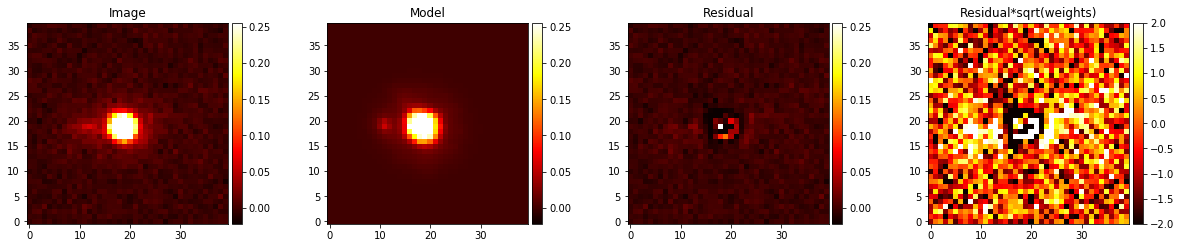

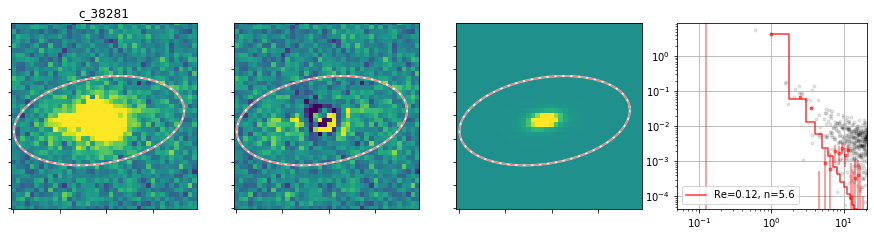

In [41]:
name = 'c_38281'
fit(name,cont = [('sersic',0,0,1,0), ('sersic',-7,-1,0.1,4)])
test(name)

Latest galfit file = galfit.129
name = c_38281
Component 1: fittype = sersic, sersic = 0.5, RA = 60.7439, Dec = 61.6906, radius = 0.757, mag = 12.901, axis ratio = 0.5, position angle = 6.0137
chisq = 13029.0, chisqnu = 1.28
 chisq_calc = 58.895782470703125, chisqnu_calc = 0.9202466011047363
Rcumul = [142.37681721]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


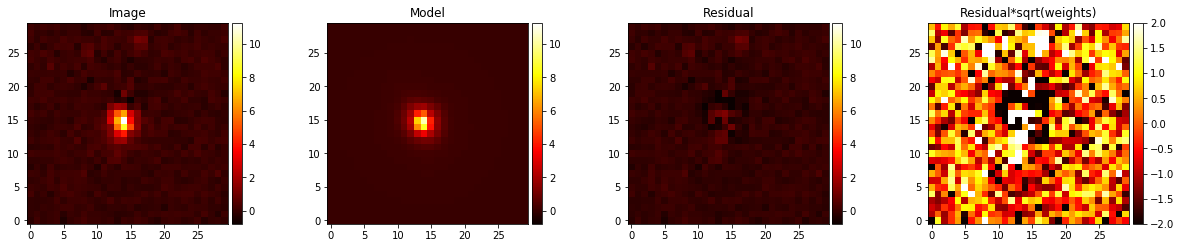

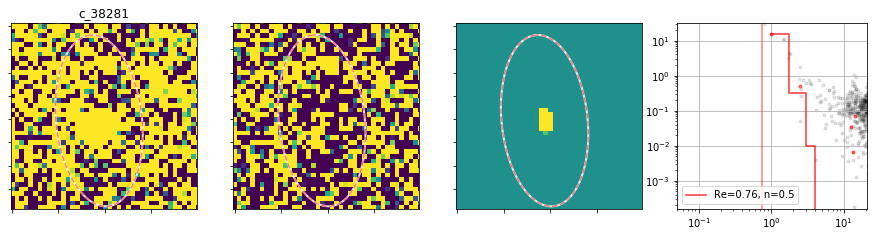

In [35]:
name = 'c_38281'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_17357

Latest galfit file = galfit.156
name = s_17357, ra = 53.17440160432943, dec = -27.86740374663276
Component 1: fittype = sersic, sersic = 5.9822, RA = 60.3055, Dec = 60.456, radius = 0.1, mag = 16.247, axis ratio = 0.5, position angle = -35.93
Component 2: fittype = sersic, sersic = 5.4975, RA = 60.2027, Dec = 60.5008, radius = 0.1, mag = 16.365, axis ratio = 0.5, position angle = -36.716
chisq = 5270.9, chisqnu = 1.733
 chisq_calc = 605.99365234375, chisqnu_calc = 2.4435227917086695
Rcumul = [167.30733336]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


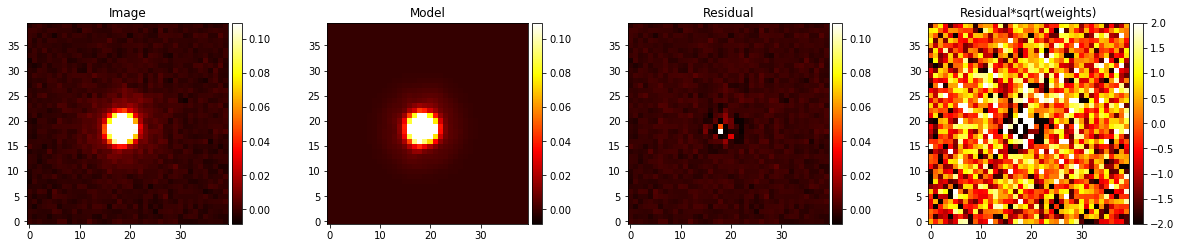

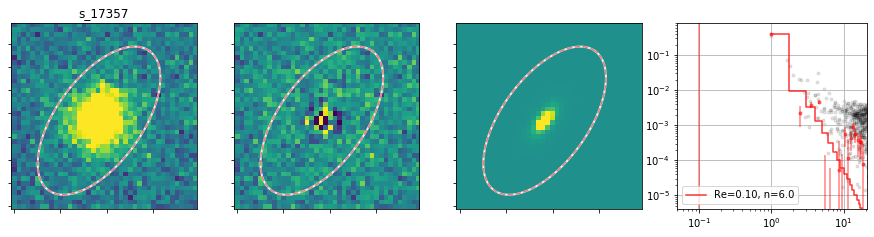

In [65]:
name = 's_17357'
# fit(name,cont = [('sersic',0,0,1,0)])
fit(name,cont = [('sersic',-2,-3,1,0),('sersic',-3,-2,1,0.5)])
test(name)

Latest galfit file = galfit.130
name = s_17357
Component 1: fittype = sersic, sersic = 1.1383, RA = 60.3045, Dec = 60.3166, radius = 0.1, mag = 15.627, axis ratio = 0.5, position angle = 42.3829
chisq = 26518.0, chisqnu = 1.949
 chisq_calc = 9.464032173156738, chisqnu_calc = 0.14787550270557404
Rcumul = [14.45073903]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


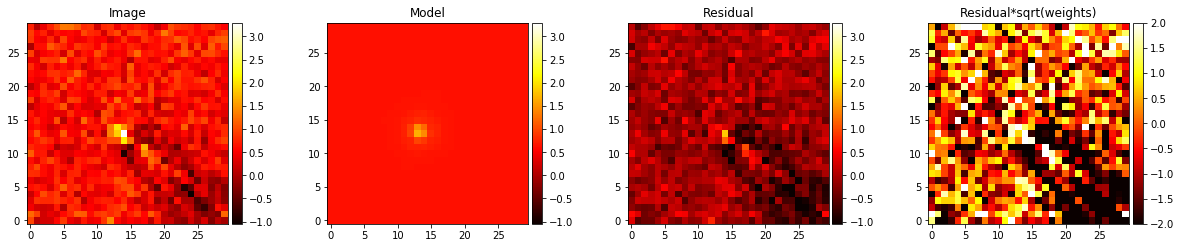

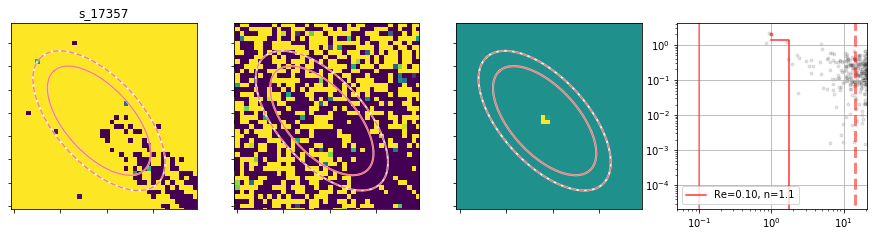

In [36]:
name = 's_17357'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# c_37582

Latest galfit file = galfit.142
name = c_37582, ra = 150.0869906242017, dec = 2.413311868721494
Component 1: fittype = sersic, sersic = 1.0888, RA = 60.821, Dec = 61.1799, radius = 0.1, mag = 16.053, axis ratio = 0.5, position angle = -41.938
chisq = 14305.0, chisqnu = 6.418
 chisq_calc = 59.73345947265625, chisqnu_calc = 0.9333353042602539
Rcumul = [168.67639184]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


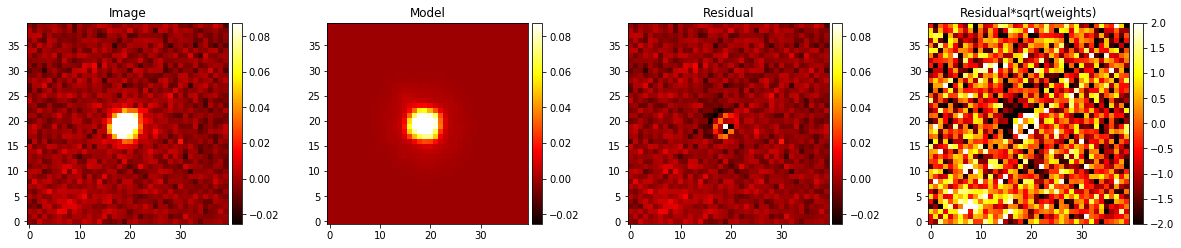

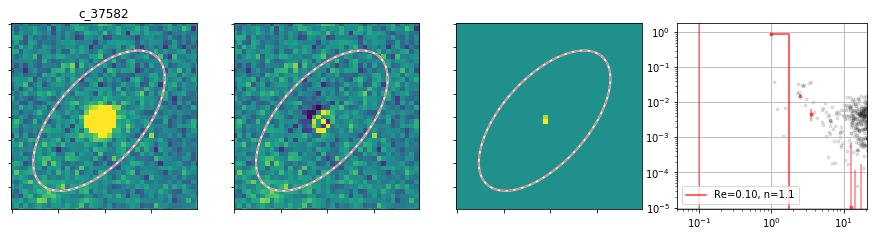

In [48]:
name = 'c_37582'
fit(name,cont = [('sersic',0,0,1,1.5)])
# fit(name,cont = [('sersic',0,0,1,0.75),('expdisk',0,0,0.5,0.75)])
# fit(name,cont = [('psf',0,0,1,0),('psf',-2,-1,1,1)])
test(name)

Latest galfit file = galfit.131
name = c_37582
Component 1: fittype = sersic, sersic = 8.0, RA = 60.4234, Dec = 61.4107, radius = 0.1, mag = 16.207, axis ratio = 0.5, position angle = 37.9801
chisq = 12958.0, chisqnu = 1.271
 chisq_calc = 4.91719388961792, chisqnu_calc = 0.07683115452528
Rcumul = [169.11490846]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


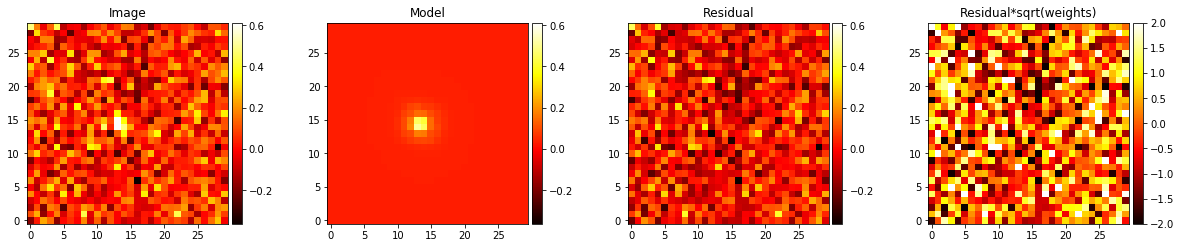

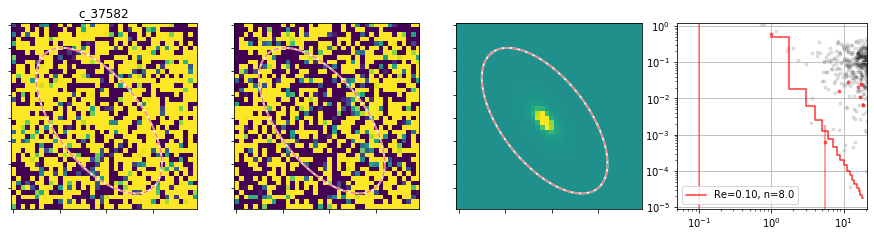

In [37]:
name = 'c_37582'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_17197

Latest galfit file = galfit.115
name = s_17197, ra = 53.22086120128451, dec = -27.8649891710237
Component 1: fittype = sersic, sersic = 1.1224, RA = 62.1145, Dec = 59.8283, radius = 0.9043, mag = 18.638, axis ratio = 0.6079, position angle = 50.9543
Component 2: fittype = sersic, sersic = 2.3686, RA = 58.2005, Dec = 61.7007, radius = 0.8758, mag = 19.878, axis ratio = 0.5, position angle = 41.9819
Component 3: fittype = sersic, sersic = 0.5, RA = 53.276, Dec = 64.6214, radius = 1.9396, mag = 19.619, axis ratio = 0.5, position angle = 59.037
Component 4: fittype = sersic, sersic = 0.5, RA = 67.7335, Dec = 59.9927, radius = 1.3704, mag = 20.725, axis ratio = 0.5, position angle = -88.133
Component 5: fittype = sersic, sersic = 0.5, RA = 74.5251, Dec = 53.9242, radius = 1.067, mag = 20.766, axis ratio = 0.5, position angle = 12.4806
chisq = 12588.0, chisqnu = 12.32
 chisq_calc = 17.863479614257812, chisqnu_calc = 0.5582337379455566
Rcumul = [139.3585302]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


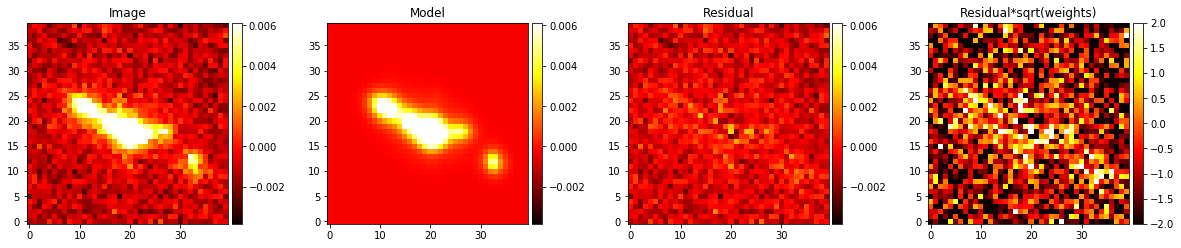

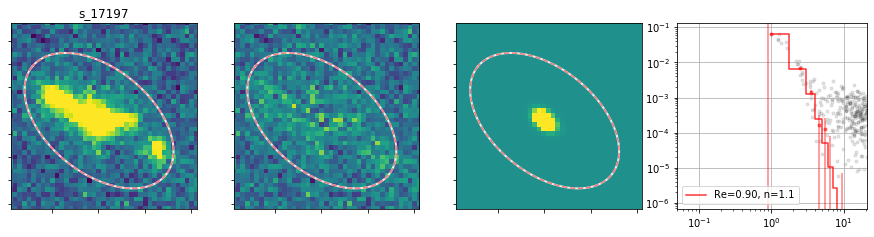

In [18]:
name = 's_17197'
fit(name,cont = [('sersic',0,0,2,0),('sersic',-3,1,3,0.3),('sersic',-8,4,3,0.5),('sersic',8,-1,2,0.8),('sersic',15,-5,2,0.8)])
# fit(name,cont = [('psf',0,0,2,0),('psf',-3,1,3,0.3),('psf',-8,4,3,0.5),('psf',8,-1,2,0.8)])
test(name)

Latest galfit file = galfit.132
name = s_17197
Component 1: fittype = sersic, sersic = 0.5, RA = 62.2321, Dec = 59.6624, radius = 1.1678, mag = 17.543, axis ratio = 0.5, position angle = 17.4675
chisq = 17313.0, chisqnu = 1.243
 chisq_calc = 11.459423065185547, chisqnu_calc = 0.17905348539352417
Rcumul = [17.11994248]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


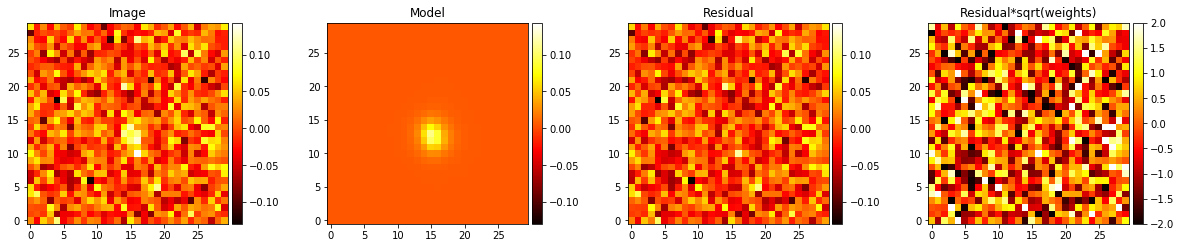

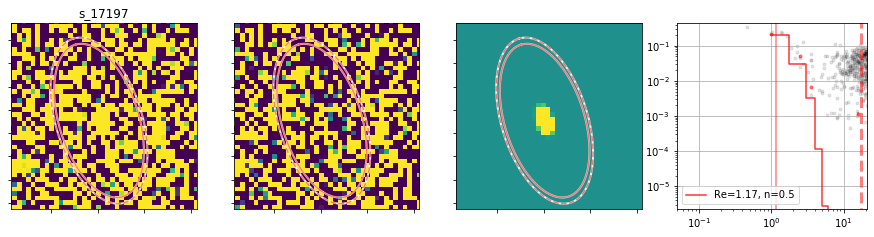

In [38]:
name = 's_17197'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_12390

Latest galfit file = galfit.158
name = s_12390, ra = 53.07885559013224, dec = -27.88415606612199
Component 1: fittype = sersic, sersic = 8.0, RA = 61.0797, Dec = 60.9472, radius = 0.3139, mag = 17.716, axis ratio = 0.5033, position angle = -79.197
chisq = 608.36, chisqnu = 1.314
 chisq_calc = 21.116661071777344, chisqnu_calc = 0.08248695731163025
Rcumul = [146.85317459]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


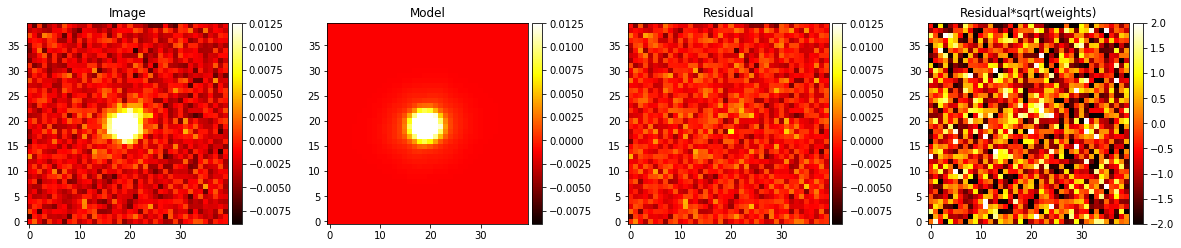

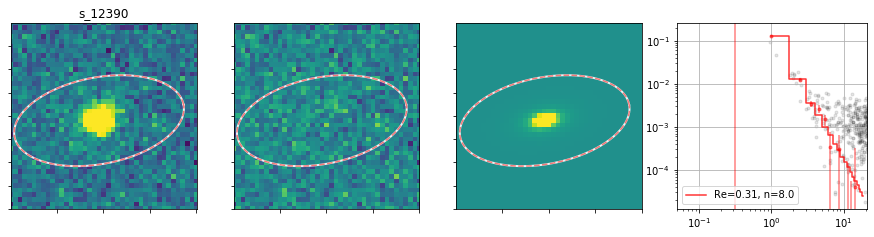

In [67]:
name = 's_12390'
fit(name,cont = [('sersic',0,0,1,0)])
test(name)

Latest galfit file = galfit.133
name = s_12390
Component 1: fittype = sersic, sersic = 0.9991, RA = 61.6558, Dec = 60.8248, radius = 0.1, mag = 15.602, axis ratio = 0.5, position angle = -49.65
chisq = 10474.0, chisqnu = 1.214
 chisq_calc = 11.682043075561523, chisqnu_calc = 0.1825319230556488
Rcumul = [169.09342418]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


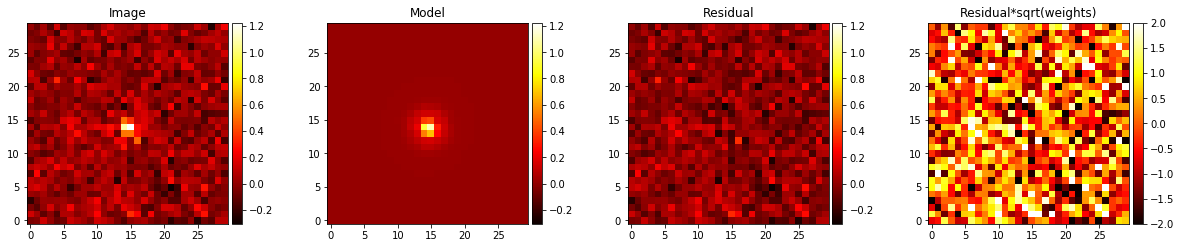

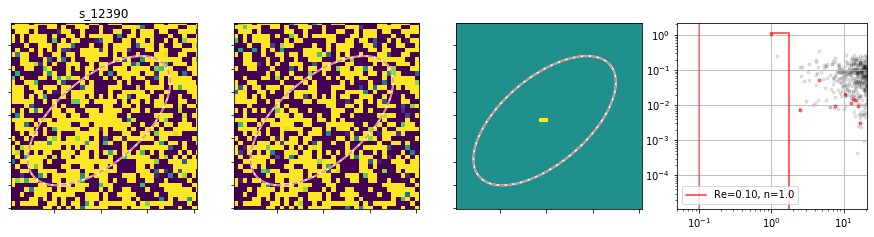

In [39]:
name = 's_12390'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_18207

Latest galfit file = galfit.160
name = s_18207, ra = 53.2700046611299, dec = -27.86128119662747
Component 1: fittype = sersic, sersic = 1.3891, RA = 60.8871, Dec = 60.7237, radius = 0.5648, mag = 19.078, axis ratio = 0.5, position angle = 47.2307
chisq = 8431.5, chisqnu = 5.034
 chisq_calc = 29.450878143310547, chisqnu_calc = 0.11504249274730682
Rcumul = [170.16606793]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


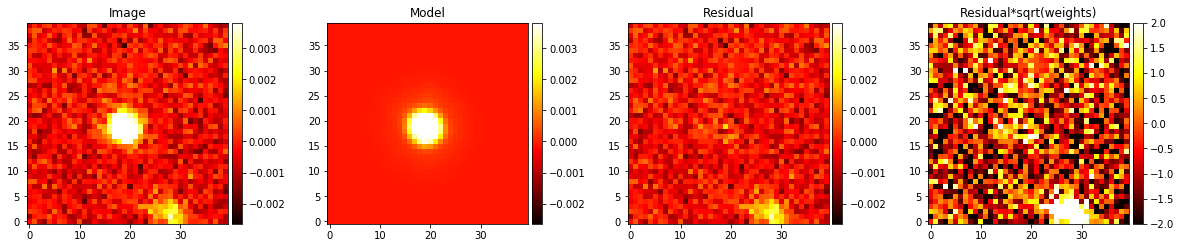

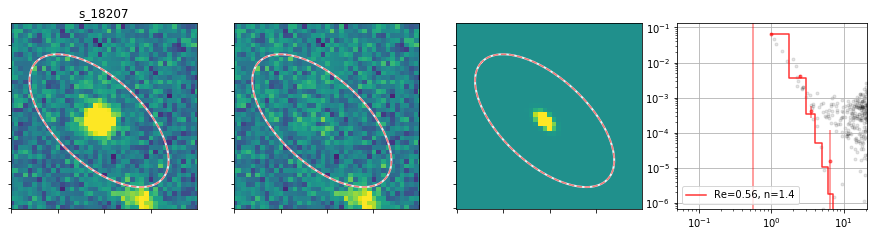

In [69]:
name = 's_18207'
fit(name, cont = [('sersic',0,0,1,0)])
test(name)

Latest galfit file = galfit.134
name = s_18207
Component 1: fittype = sersic, sersic = 0.5, RA = 60.6883, Dec = 59.7845, radius = 0.871, mag = 16.492, axis ratio = 0.5, position angle = 46.59
chisq = 22384.0, chisqnu = 2.492
 chisq_calc = 10.10097885131836, chisqnu_calc = 0.15782779455184937
Rcumul = [16.08697675]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


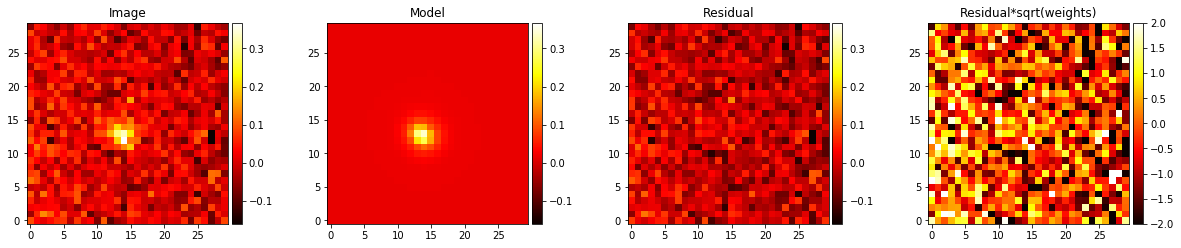

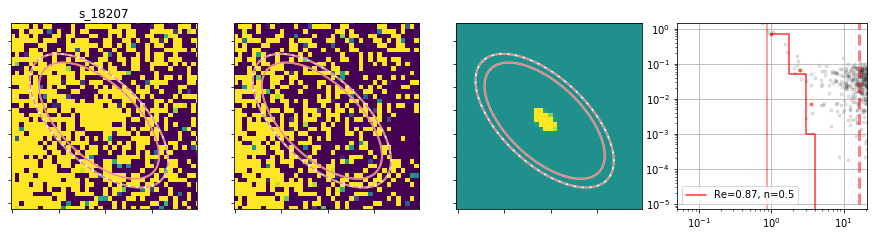

In [40]:
name = 's_18207'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_44106

Latest galfit file = galfit.146
name = s_44106, ra = 53.16947213899689, dec = -27.76565403437542
Component 1: fittype = psf   , sersic = 1.0, RA = 60.5725, Dec = 60.1494, radius = 1.0, mag = 20.974, axis ratio = 0.1, position angle = -45.0
chisq = 1892.2, chisqnu = 1.346
 chisq_calc = 17.71696662902832, chisqnu_calc = 0.06920690089464188
Rcumul = [18.05147797]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


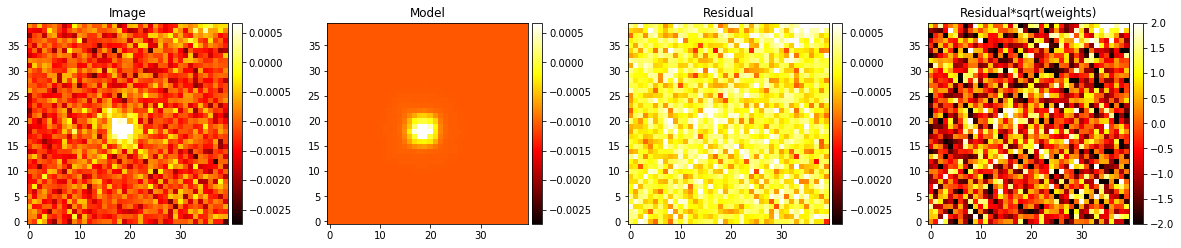

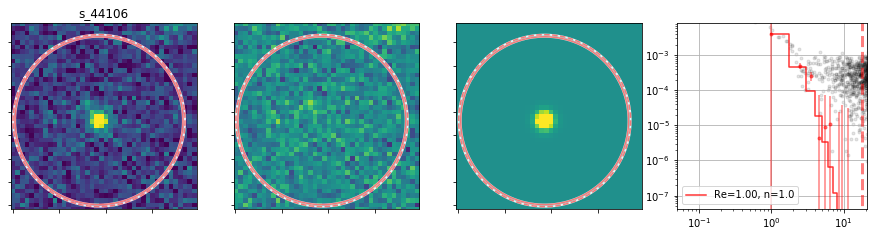

In [53]:
name = 's_44106'
fit(name, cont = [('psf',0,0,1,0)]) # chisqnu 1.34 with sersic => not worth it
test(name)

Latest galfit file = galfit.161
name = s_44106
Component 1: fittype = psf   , sersic = 1.0, RA = 60.8592, Dec = 59.9973, radius = 1.0, mag = 17.676, axis ratio = 0.1, position angle = -45.0
chisq = 16889.0, chisqnu = 1.188
 chisq_calc = 5.464921474456787, chisqnu_calc = 0.0853893980383873
Rcumul = [85.66355837]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


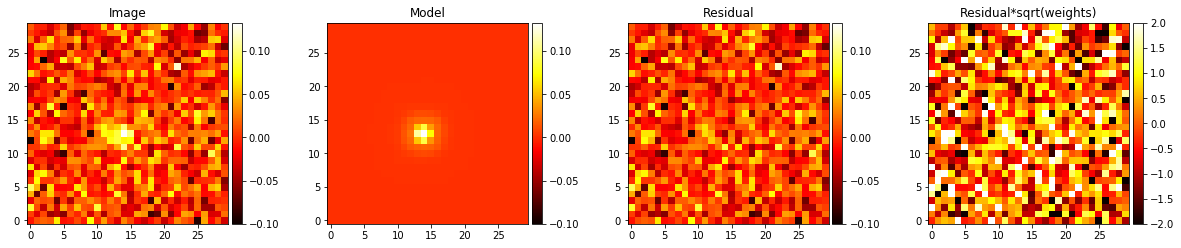

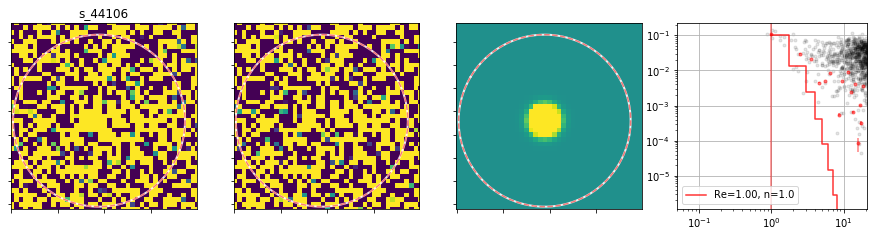

In [70]:
name = 's_44106'
linefit(name,line = [('psf',0,0,1,0)])
test(name)

# s_36953

Latest galfit file = galfit.164
name = s_36953, ra = 53.14380043878165, dec = -27.79094064011957
Component 1: fittype = psf   , sersic = 1.0, RA = 60.9796, Dec = 61.1417, radius = 1.0, mag = 21.226, axis ratio = 0.1, position angle = -45.0
chisq = 14428.0, chisqnu = 6.594
 chisq_calc = 14.253305435180664, chisqnu_calc = 0.05567697435617447
Rcumul = [84.76711919]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


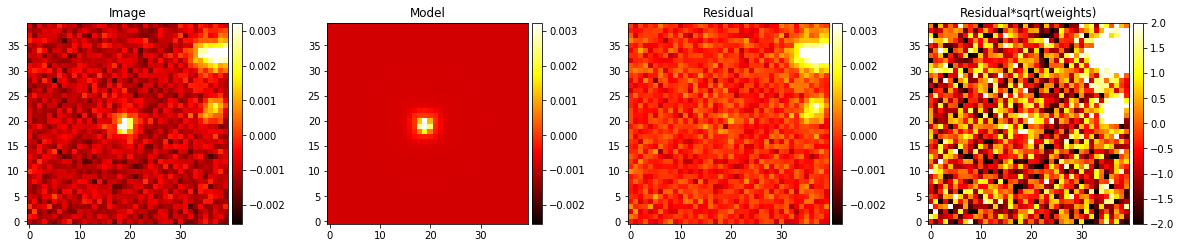

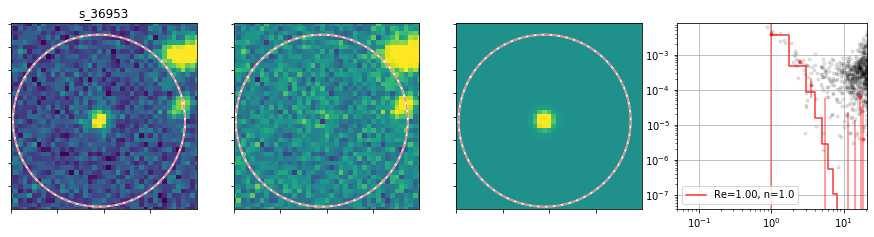

In [73]:
name = 's_36953'
fit(name, cont = [('psf',0,0,1,0)]) # smae chisqnu with sersic and psf, but is this chisqnu reliable?
test(name)

Latest galfit file = galfit.136
name = s_36953
Component 1: fittype = sersic, sersic = 6.8069, RA = 60.7883, Dec = 61.2739, radius = 0.1, mag = 17.683, axis ratio = 0.5, position angle = 12.5326
chisq = 19107.0, chisqnu = 1.361
 chisq_calc = 15.866677284240723, chisqnu_calc = 0.2479168325662613
Rcumul = [15.56893729]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


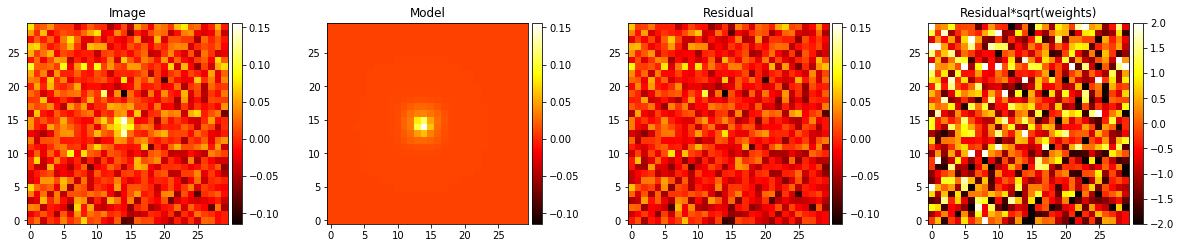

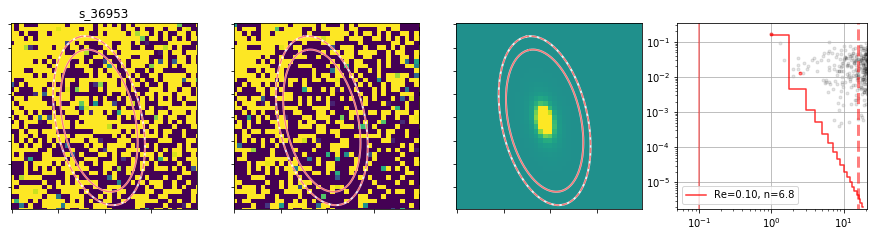

In [42]:
name = 's_36953'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_43831

Latest galfit file = galfit.166
name = s_43831, ra = 53.16741164136695, dec = -27.76688063993047
Component 1: fittype = sersic, sersic = 0.5775, RA = 61.3085, Dec = 60.1871, radius = 1.2677, mag = 20.422, axis ratio = 0.5, position angle = -80.309
chisq = 7765.6, chisqnu = 2.893
 chisq_calc = 17.700645446777344, chisqnu_calc = 0.069143146276474
Rcumul = [147.93827318]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


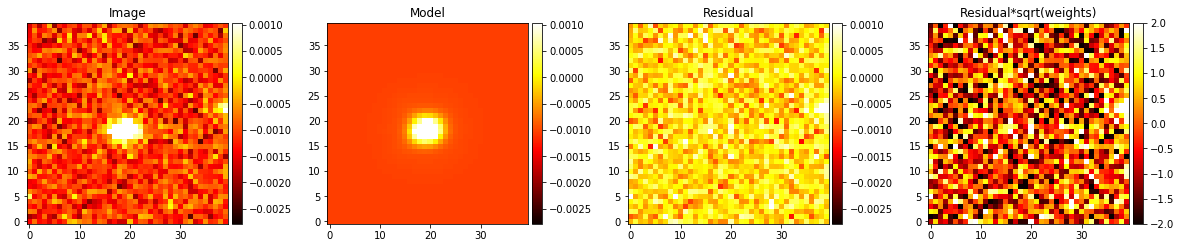

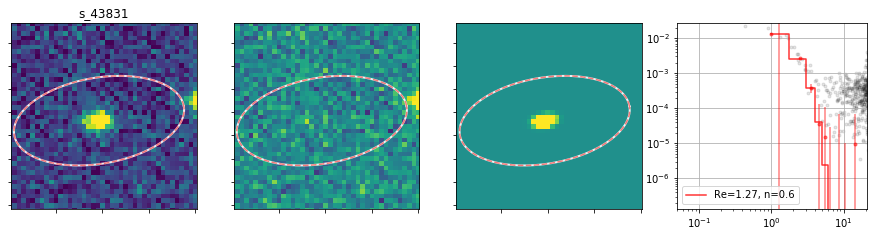

In [75]:
name = 's_43831'
fit(name, cont = [('sersic',0,0,1,0)]) # 2.97 with psf, 2.89 with sersic; i think it would be smaller without the source at the right edge
test(name)

Latest galfit file = galfit.137
name = s_43831
Component 1: fittype = sersic, sersic = 1.3461, RA = 62.2858, Dec = 60.3108, radius = 0.1, mag = 17.827, axis ratio = 0.5, position angle = -6.1059
chisq = 17131.0, chisqnu = 1.205
 chisq_calc = 12.66755485534668, chisqnu_calc = 0.19793054461479187
Rcumul = [143.33204702]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


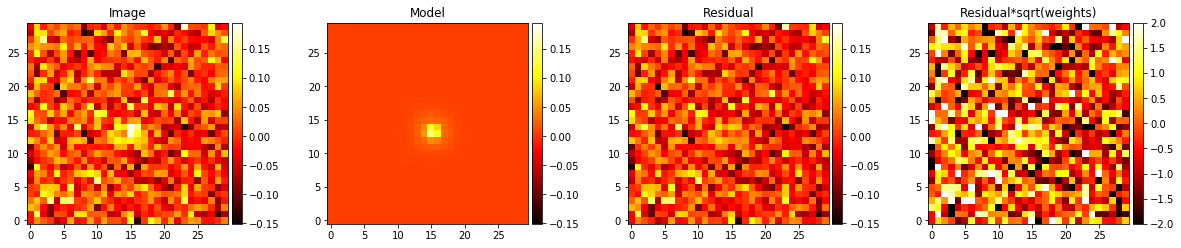

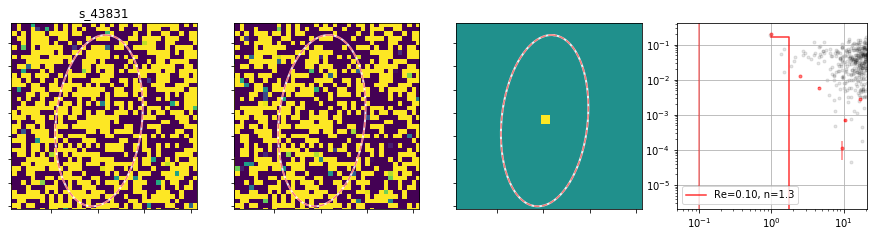

In [43]:
name = 's_43831'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# n_16335

Latest galfit file = galfit.168
name = n_16335, ra = 189.0967667748389, dec = 62.20985019552895
Component 1: fittype = sersic, sersic = 0.5, RA = 61.0125, Dec = 61.2612, radius = 0.863, mag = 18.687, axis ratio = 0.6907, position angle = -79.97
chisq = 446.35, chisqnu = 1.193
 chisq_calc = 32.04930877685547, chisqnu_calc = 0.12519261240959167
Rcumul = [110.90229229]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


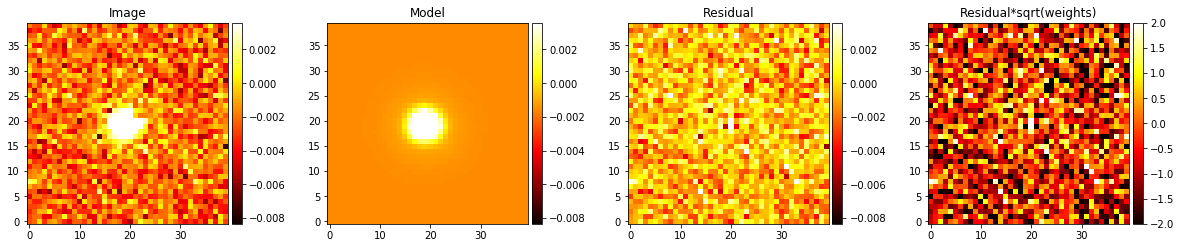

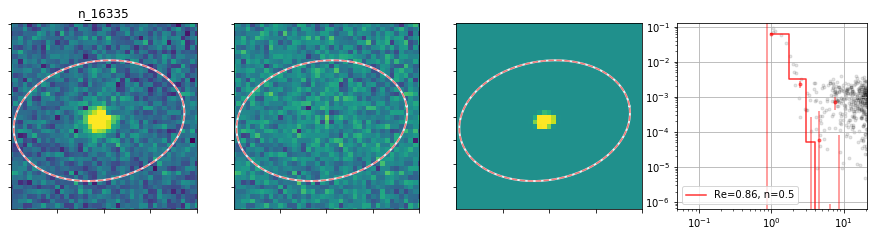

In [77]:
name = 'n_16335'
fit(name, cont = [('sersic',0,0,1,0)]) # 1.77 with psf, 1.19 with sersic
test(name)

Latest galfit file = galfit.138
name = n_16335
Component 1: fittype = sersic, sersic = 1.125, RA = 61.6734, Dec = 61.4663, radius = 2.0358, mag = 16.487, axis ratio = 0.5, position angle = -39.185
chisq = 15474.0, chisqnu = 1.407
 chisq_calc = 2.3415656089782715, chisqnu_calc = 0.03658696264028549
Rcumul = [17.95418582]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


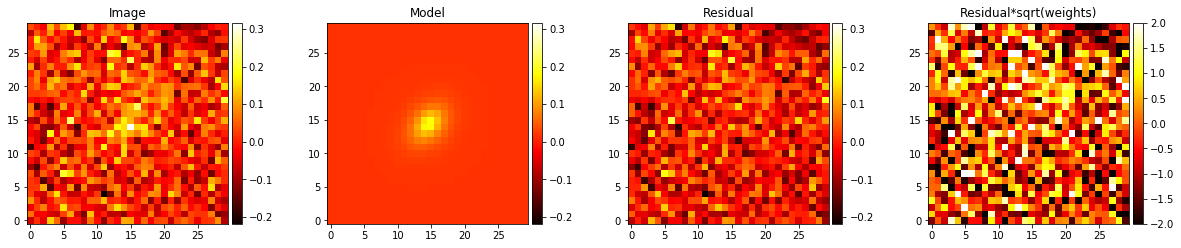

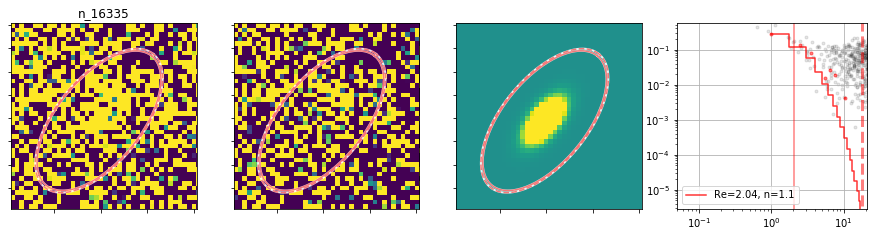

In [44]:
name = 'n_16335'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# n_39376

Latest galfit file = galfit.170
name = n_39376, ra = 189.0795302157769, dec = 62.31532989665211
Component 1: fittype = sersic, sersic = 0.9706, RA = 62.2885, Dec = 60.0928, radius = 0.1, mag = 18.684, axis ratio = 0.5, position angle = -57.087
chisq = 633.56, chisqnu = 2.215
 chisq_calc = 25.61309814453125, chisqnu_calc = 0.1000511646270752
Rcumul = [17.91766426]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


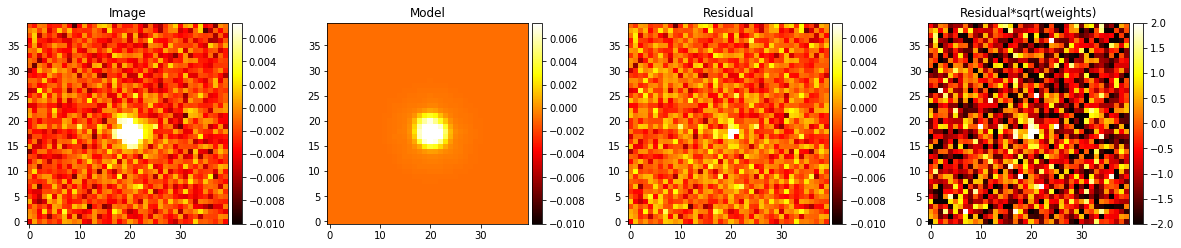

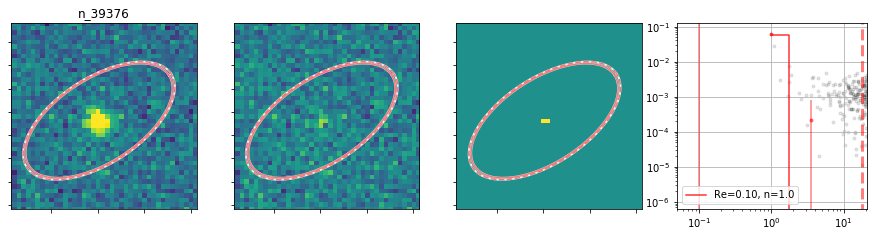

In [79]:
name = 'n_39376'
fit(name, cont = [('sersic',0,0,1,0)]) # 2.116 with psf, 2.215 with sersic
test(name)

Latest galfit file = galfit.139
name = n_39376
Component 1: fittype = sersic, sersic = 2.6384, RA = 61.8843, Dec = 60.2538, radius = 0.1, mag = 15.375, axis ratio = 0.5, position angle = 26.9973
chisq = 9956.2, chisqnu = 1.257
 chisq_calc = 5.993967056274414, chisqnu_calc = 0.09365573525428772
Rcumul = [162.80251445]


/Users/meghanakilli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


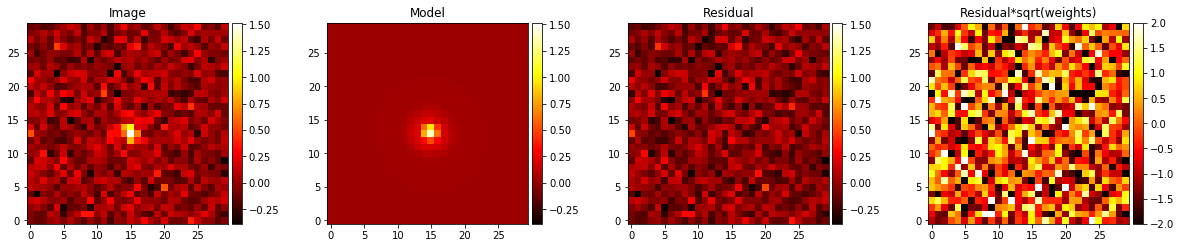

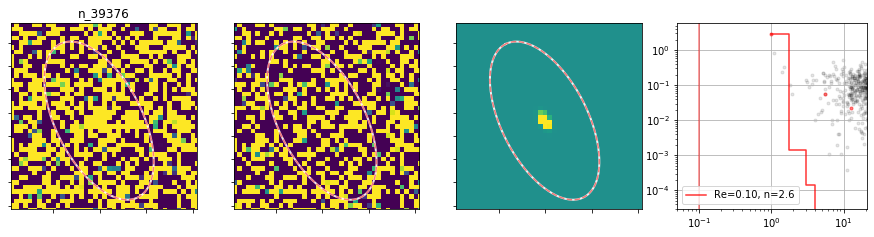

In [45]:
name = 'n_39376'
linefit(name,line = [('sersic',0,0,1,0)])
test(name)

# s_33531

# s_42662

# s_21181

# s_26144